In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle
import sys
sys.path.append(os.path.dirname(os.path.dirname(os.getcwd())))

import time

from methods.utils import dynamic
from methods import mmca, mcmc
from methods.utils import update_social_attention, dynamic, calculate_susceptibility

from methods.mmca_threshold import MMCA_threshold

from parameters import Initial_data
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda
Using device: cuda


In [2]:
# 导入默认参数
file_path = os.path.join(os.path.dirname(os.path.dirname(os.getcwd())), 'parameters/inital_data_1.pkl')
with open(file_path, 'rb') as f:
    init_data = pickle.load(f)

epi_paras = torch.tensor(init_data['epi_paras'], dtype=torch.float32).to(device)
soc_paras = torch.tensor(init_data['soc_paras'], dtype=torch.float32).to(device)
features_state = torch.tensor(init_data['init_state'], dtype=torch.float32).to(device)
features_prob = torch.tensor(init_data['init_prob'], dtype=torch.float32).to(device)
P_rows, P_cols = init_data['P_matrix'].nonzero()
P_edge_index = torch.tensor(np.array([P_rows, P_cols]), dtype=torch.long).to(device)
I_rows, I_cols = init_data['I_matrix'].nonzero()
I_edge_index = torch.tensor(np.array([I_rows, I_cols]), dtype=torch.long).to(device)

# 例子

In [ ]:
para_len = 128
node_num =  features_state.shape[0]
soc_paras_example = soc_paras.unsqueeze(0).repeat(para_len, 1)
epi_paras_example = epi_paras.unsqueeze(0).repeat(para_len, 1, 1) 

# 替换掉自己的参数
beta_log = torch.linspace(-3.0, -1.0, para_len)
beta_values = 10 ** beta_log
beta = beta_values.unsqueeze(1).expand(-1, node_num).to(device)
epi_paras_example[...,0] = beta
# epi_paras_example[...,1] = 0.1
# epi_paras_example[...,2] = 0.01

features_state_tensor = features_state.unsqueeze(0).repeat(para_len, 1, 1).to(device)
mcmc_method = mcmc.MCMC(para_len, node_num, device,delta_t=1)
t_max = 500000
t_ave = int(t_max*0.8)

start = time.time()
rho = mcmc_method.update_QS(features_state_tensor, epi_paras_example, soc_paras_example, P_edge_index, I_edge_index, t_max)

In [214]:
t_ave = int(t_max*0.5)
chis, rho_means = calculate_susceptibility(rho[:,-t_ave:] ,node_num)

print(chis)
print(rho_means)
print(time.time()-start)


torch.save(chis.cpu(), 'data/chi_values_example.pt')
torch.save(rho_means.cpu(), 'data/rho_mean_values_example.pt')
torch.save(beta_log.cpu(), 'data/beta_values_example.pt')

tensor([0.0149, 0.0049, 0.0381, 0.0591, 0.0034, 0.0721, 0.0782, 0.0699, 0.0516,
        0.0082, 0.1012, 0.0660, 0.0531, 0.0841, 0.0237, 0.2587, 0.2558, 0.2495,
        0.3248, 0.2435, 0.1529, 0.1657, 0.1387, 0.0896, 0.0475, 0.0417, 0.0374,
        0.0304, 0.0287, 0.0296, 0.0308, 0.0350, 0.0354, 0.0299, 0.0267, 0.0225,
        0.0205, 0.0176, 0.0170, 0.0162, 0.0157, 0.0147, 0.0158, 0.0171, 0.0154,
        0.0078, 0.0029, 0.0013, 0.0008, 0.0007, 0.0007, 0.0007, 0.0007, 0.0007,
        0.0006, 0.0006, 0.0006, 0.0006, 0.0007, 0.0008, 0.0010, 0.0017, 0.0039,
        0.0086, 0.0143, 0.0145, 0.0144, 0.0133, 0.0124, 0.0130, 0.0129, 0.0124,
        0.0112, 0.0110, 0.0109, 0.0102, 0.0096, 0.0095, 0.0095, 0.0096, 0.0092,
        0.0088, 0.0086, 0.0081, 0.0073, 0.0072, 0.0066, 0.0044, 0.0023, 0.0013,
        0.0010, 0.0011, 0.0010, 0.0011, 0.0011, 0.0012, 0.0012, 0.0013, 0.0013,
        0.0013, 0.0014, 0.0014, 0.0015, 0.0016, 0.0016, 0.0017, 0.0017, 0.0018,
        0.0019, 0.0020, 0.0021, 0.0022, 

tensor(0.0226)


C:\Users\95406\AppData\Local\Temp\ipykernel_2720\2104015647.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  chis = torch.load('data/chi_values_example.pt')
C:\Users\9540

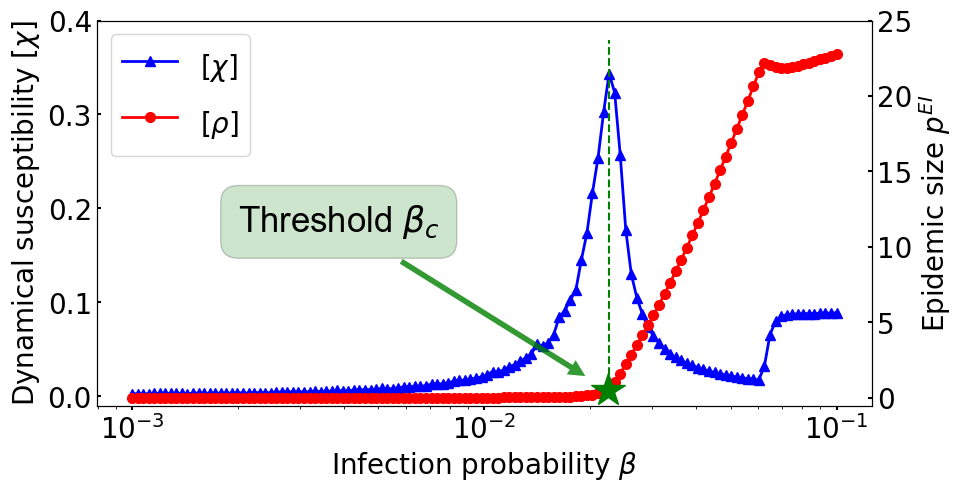

In [23]:

# 加载保存的张量
chis = torch.load('data/chi_values_example.pt')
rho_means = torch.load('data/rho_mean_values_example.pt')
beta_log = torch.load('data/beta_values_example.pt')


max_indices = torch.argmax(torch.nan_to_num(chis, nan=0.0))
beta_c = 10 ** beta_log[max_indices]
print(beta_c)

# 创建图形和第一个 y 轴
fig, ax1 = plt.subplots(figsize=(10, 5))

# 绘制第一条曲线（左侧 y 轴：chis）
ax1.plot(10**beta_log.numpy(), chis.numpy(), label=r'$[\chi]$', color='blue', marker='^', linestyle='-',\
          linewidth=2, markersize=7)

# 创建第二个 y 轴（共享 x 轴）
ax2 = ax1.twinx()

# 绘制第二条曲线（右侧 y 轴：rho_means）
ax2.plot(10**beta_log.numpy(), rho_means.numpy(), label=r'$[\rho]$', color='red', marker='o', linestyle='-',\
         linewidth=2, markersize=7)

# 添加图例
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', fontsize=20, handlelength=2, handleheight=2)
# ax2.set_xlim(10**(-2.5), 10**(-1.5))
# plt.yscale('log')
ax1.set_xlabel(r'Infection probability $\beta$', fontsize=20, color='black')
ax1.set_ylabel(r'Dynamical susceptibility $[\chi]$', fontsize=20, color='black')
ax1.set_xlim(10**(-3.1), 10**(-0.9))
ax1.set_ylim(-0.01, 0.4)
ax2.set_ylim(-0.5, 25)
ax2.set_ylabel(r'Epidemic size $p^{EI}$', fontsize=20, color='black')
ax1.tick_params(axis='x', labelsize=20, length=3, width=1.5, color='black', direction='out')
ax1.tick_params(axis='y', labelsize=20, length=3, width=1.5, color='black', direction='in')
ax2.tick_params(axis='y', labelsize=20, length=3, width=1.5, color='black', direction='in')


ax2.annotate('', xy=(0.0225, 0.5), xytext=(0.005, 10),
             arrowprops=dict(facecolor='green', alpha=0.8, edgecolor='none', shrink=0.1),
             zorder=0)  # zorder=0 将箭头置于底层
ax2.plot(0.0225, 0.5, marker='*', markersize=25, color='green', linestyle='none')
# 添加文本标签
ax2.text(0.002, 11, r'Threshold $\beta_c$', color='black',
         fontdict={'family': 'Arial', 'weight': 'normal', 'size': 25},
         bbox=dict(boxstyle='round,pad=0.5', edgecolor='black', facecolor='green', alpha=0.2))

plt.axvline(x=beta_c, ymin=0.05, ymax=0.95, color='green', linestyle='--')
plt.xscale('log')


# 显示图形
plt.show()
fig.savefig(f'../figs/Num_verification/Threshold/example.svg', bbox_inches='tight')

# 理论阈值

In [3]:
epi_paras = torch.tensor(init_data['epi_paras'], dtype=torch.float32).to(device)
soc_paras = torch.tensor(init_data['soc_paras'], dtype=torch.float32).to(device)
I_matrix = init_data['I_matrix']
I_rows, I_cols = init_data['I_matrix'].nonzero()
I_edge_index = torch.tensor(np.array([I_rows, I_cols]), dtype=torch.long).to(device)
P_matrix = init_data['P_matrix']
para_len = 50
node_num =  epi_paras.shape[0]

In [5]:
soc_paras_mu = soc_paras.unsqueeze(0).repeat(para_len, 1)
epi_paras_mu = epi_paras.unsqueeze(0).repeat(para_len, 1, 1) 
#  替换掉自己的参数
mu = 10 ** torch.linspace(-2, 0, para_len).to(device)
# mu = torch.tensor(0.1).repeat(para_len).to(device)
print(mu)
epi_paras_mu[...,2] = mu.unsqueeze(1).expand(-1, node_num).to(device)
mmca_threshold = MMCA_threshold()

init_pA =  torch.rand(para_len, node_num).to(device)
max_iter = 1000
tol = 1e-16

p_A = mmca_threshold.iteration(max_iter, tol, init_pA, epi_paras_mu, soc_paras_mu, I_edge_index)

# Case 1
max_eig_H = mmca_threshold.max_eig_H(p_A, epi_paras_mu, P_matrix)
beta_mu_1 = mmca_threshold.threshold(max_eig_H, epi_paras_mu, soc_paras_mu)
print(beta_mu_1)

# Case 2 
max_eig_H_approx = mmca_threshold.max_eig_H_appox(p_A, epi_paras_mu, P_matrix)
beta_mu_2 = mmca_threshold.threshold(max_eig_H_approx, epi_paras_mu, soc_paras_mu)
print(beta_mu_2)

# Case 3
beta_mu_3 = mmca_threshold.degree_MCMC_threshold(p_A, epi_paras_mu, soc_paras_mu, P_matrix)
print(beta_mu_3)

# Case 4
beta_mu_4 = mmca_threshold.mean_MCMC_threshold(p_A, epi_paras_mu, soc_paras_mu, P_matrix)
print(beta_mu_4)


tensor([0.0100, 0.0110, 0.0121, 0.0133, 0.0146, 0.0160, 0.0176, 0.0193, 0.0212,
        0.0233, 0.0256, 0.0281, 0.0309, 0.0339, 0.0373, 0.0409, 0.0450, 0.0494,
        0.0543, 0.0596, 0.0655, 0.0720, 0.0791, 0.0869, 0.0954, 0.1048, 0.1151,
        0.1265, 0.1389, 0.1526, 0.1677, 0.1842, 0.2024, 0.2223, 0.2442, 0.2683,
        0.2947, 0.3237, 0.3556, 0.3907, 0.4292, 0.4715, 0.5179, 0.5690, 0.6251,
        0.6866, 0.7543, 0.8286, 0.9103, 1.0000], device='cuda:0')
tensor([0.0084, 0.0085, 0.0087, 0.0088, 0.0090, 0.0091, 0.0093, 0.0095, 0.0098,
        0.0100, 0.0103, 0.0105, 0.0109, 0.0112, 0.0116, 0.0120, 0.0124, 0.0129,
        0.0134, 0.0139, 0.0145, 0.0152, 0.0159, 0.0166, 0.0174, 0.0183, 0.0192,
        0.0201, 0.0212, 0.0222, 0.0234, 0.0246, 0.0259, 0.0272, 0.0286, 0.0300,
        0.0315, 0.0331, 0.0346, 0.0362, 0.0379, 0.0396, 0.0412, 0.0429, 0.0446,
        0.0463, 0.0480, 0.0496, 0.0513, 0.0528])
tensor([0.0084+0.j, 0.0086+0.j, 0.0087+0.j, 0.0088+0.j, 0.0090+0.j, 0.0091+0.j, 0.009

In [7]:
soc_paras_sigma = soc_paras.unsqueeze(0).repeat(para_len, 1)
epi_paras_sigma = epi_paras.unsqueeze(0).repeat(para_len, 1, 1) 
#  替换掉自己的参数
sigma = 10 ** torch.linspace(-2, 0, para_len).to(device)
epi_paras_sigma[...,1] = sigma.unsqueeze(1).expand(-1, node_num).to(device)
mmca_threshold = MMCA_threshold()

init_pA =  torch.rand(para_len, node_num).to(device)
max_iter = 1000
tol = 1e-16

p_A = mmca_threshold.iteration(max_iter, tol, init_pA, epi_paras_sigma, soc_paras_sigma, I_edge_index)

# Case 1
max_eig_H = mmca_threshold.max_eig_H(p_A, epi_paras_sigma, P_matrix)
beta_sigma_1 = mmca_threshold.threshold(max_eig_H, epi_paras_sigma, soc_paras_sigma)
print(beta_sigma_1)

# Case 2 
max_eig_H_approx = mmca_threshold.max_eig_H_appox(p_A, epi_paras_sigma, P_matrix)
beta_sigma_2 = mmca_threshold.threshold(max_eig_H_approx, epi_paras_sigma, soc_paras_sigma)
print(beta_sigma_2)

# Case 3
beta_sigma_3 = mmca_threshold.degree_MCMC_threshold(p_A, epi_paras_sigma, soc_paras_sigma, P_matrix)
print(beta_sigma_3)

# Case 4
beta_sigma_4 = mmca_threshold.mean_MCMC_threshold(p_A, epi_paras_sigma, soc_paras_sigma, P_matrix)
print(beta_sigma_4)

tensor([0.0015, 0.0016, 0.0018, 0.0019, 0.0021, 0.0023, 0.0025, 0.0027, 0.0029,
        0.0032, 0.0034, 0.0037, 0.0040, 0.0044, 0.0047, 0.0051, 0.0054, 0.0058,
        0.0063, 0.0067, 0.0072, 0.0076, 0.0081, 0.0086, 0.0091, 0.0096, 0.0102,
        0.0107, 0.0112, 0.0118, 0.0123, 0.0129, 0.0134, 0.0139, 0.0144, 0.0149,
        0.0154, 0.0159, 0.0163, 0.0168, 0.0172, 0.0176, 0.0180, 0.0183, 0.0187,
        0.0190, 0.0193, 0.0196, 0.0198, 0.0201])
tensor([0.0015+0.j, 0.0016+0.j, 0.0018+0.j, 0.0019+0.j, 0.0021+0.j, 0.0023+0.j, 0.0025+0.j,
        0.0027+0.j, 0.0029+0.j, 0.0032+0.j, 0.0035+0.j, 0.0037+0.j, 0.0040+0.j, 0.0044+0.j,
        0.0047+0.j, 0.0051+0.j, 0.0054+0.j, 0.0058+0.j, 0.0063+0.j, 0.0067+0.j, 0.0072+0.j,
        0.0076+0.j, 0.0081+0.j, 0.0086+0.j, 0.0091+0.j, 0.0096+0.j, 0.0102+0.j, 0.0107+0.j,
        0.0113+0.j, 0.0118+0.j, 0.0123+0.j, 0.0129+0.j, 0.0134+0.j, 0.0139+0.j, 0.0144+0.j,
        0.0149+0.j, 0.0154+0.j, 0.0159+0.j, 0.0163+0.j, 0.0168+0.j, 0.0172+0.j, 0.0176+0.j,

# 阈值-MCMC

In [ ]:
para_len = 256
node_num =  features_state.shape[0]
soc_paras_sigma = soc_paras.unsqueeze(0).repeat(para_len, 1)
epi_paras_sigma = epi_paras.unsqueeze(0).repeat(para_len, 1, 1) 

# 替换掉自己的参数
beta_log = torch.linspace(-3.0, -1.0, para_len)
beta_values = 10 ** beta_log
beta = beta_values.unsqueeze(1).expand(-1, node_num).to(device)
epi_paras_sigma[...,0] = beta


features_state_tensor = features_state.unsqueeze(0).repeat(para_len, 1, 1).to(device)
mcmc_method = mcmc.MCMC(para_len, node_num, device, delta_t=1)
t_max = 50000
t_ave = int(t_max*0.5)

sigma = 10 ** torch.linspace(-2, 0, 50).to(device)
chis_sigma = torch.zeros(sigma.shape[0],para_len)
rho_means_sigma = torch.zeros(sigma.shape[0],para_len)
for i in range(sigma.shape[0]):
    epi_paras_sigma[...,1] = sigma[i]
    rho = mcmc_method.update_QS(features_state_tensor, epi_paras_sigma, soc_paras_sigma, P_edge_index, I_edge_index, t_max)
    chis, rho_means = calculate_susceptibility(rho[:,-t_ave:] ,node_num)
    chis_sigma[i], rho_means_sigma[i] = chis, rho_means
    print(f'已经完成第 {i+1} 个数据！')


torch.save(chis_sigma.cpu(), 'data/chis_sigma_values.pt')
torch.save(rho_means_sigma.cpu(), 'data/rho_means_sigma_values.pt')
torch.save(beta_log.cpu(), 'data/beta_log_sigma_values.pt')
torch.save(sigma.cpu(), 'data/sigma_values.pt')

In [ ]:
para_len = 256
node_num =  features_state.shape[0]
soc_paras_mu = soc_paras.unsqueeze(0).repeat(para_len, 1)
epi_paras_mu = epi_paras.unsqueeze(0).repeat(para_len, 1, 1) 

# 替换掉自己的参数
beta_log = torch.linspace(-2.0, -1.0, para_len)
beta_values = 10 ** beta_log
beta = beta_values.unsqueeze(1).expand(-1, node_num).to(device)
epi_paras_mu[...,0] = beta


features_state_tensor = features_state.unsqueeze(0).repeat(para_len, 1, 1).to(device)
mcmc_method = mcmc.MCMC(para_len, node_num, device, delta_t=1)
t_max = 50000
t_ave = int(t_max*0.5)

mu = 10 ** torch.linspace(-2, 0, 50).to(device)
chis_mu = torch.zeros(mu.shape[0],para_len)
rho_means_mu = torch.zeros(mu.shape[0],para_len)
for i in range(mu.shape[0]):
    epi_paras_mu[...,2] = mu[i]
    rho = mcmc_method.update_QS(features_state_tensor, epi_paras_mu, soc_paras_mu, P_edge_index, I_edge_index, t_max)
    chis, rho_means = calculate_susceptibility(rho[:,-t_ave:] ,node_num)
    chis_mu[i], rho_means_mu[i] = chis, rho_means
    # print(f'已经完成第 {i+1} 个数据！', end='\r')
    print(f'已经完成第 {i+1} 个数据！')


torch.save(chis_mu.cpu(), 'data/chis_mu_values.pt')
torch.save(rho_means_mu.cpu(), 'data/rho_means_mu_values.pt')
torch.save(beta_log.cpu(), 'data/beta_log_mu_values.pt')
torch.save(mu.cpu(), 'data/mu_values.pt')

# 对比

C:\Users\95406\AppData\Local\Temp\ipykernel_2720\560737881.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  chis_mu = torch.load('data/chis_mu_values.pt')
C:\Users\95406\

tensor([0.0100, 0.0110, 0.0121, 0.0133, 0.0146, 0.0160, 0.0176, 0.0193, 0.0212,
        0.0233, 0.0256, 0.0281, 0.0309, 0.0339, 0.0373, 0.0409, 0.0450, 0.0494,
        0.0543, 0.0596, 0.0655, 0.0720, 0.0791, 0.0869, 0.0954, 0.1048, 0.1151,
        0.1265, 0.1389, 0.1526, 0.1677, 0.1842, 0.2024, 0.2223, 0.2442, 0.2683,
        0.2947, 0.3237, 0.3556, 0.3907, 0.4292, 0.4715, 0.5179, 0.5690, 0.6251,
        0.6866, 0.7543, 0.8286, 0.9103, 1.0000])


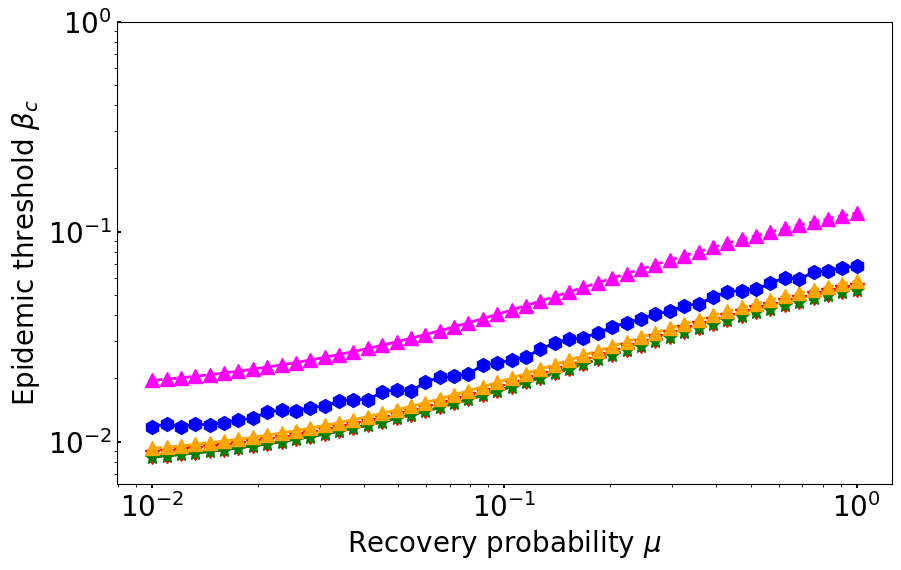

In [20]:
# 加载保存的张量
chis_mu = torch.load('data/chis_mu_values.pt')
rho_means_mu = torch.load('data/rho_means_mu_values.pt')
beta_log = torch.load('data/beta_log_mu_values.pt')
mu = torch.load('data/mu_values.pt')


max_indices = torch.argmax(torch.nan_to_num(chis_mu, nan=0.0), dim=1)
beta_c = 10 ** beta_log[max_indices]


fig, ax = plt.subplots(figsize=(10, 6))
print(mu)
ax.plot(mu.cpu(), beta_mu_1, label="Microscopic", marker="v", linestyle="--", color="red", linewidth=2, markersize=10)  # 绘制第一条折线
ax.plot(mu.cpu(), beta_mu_2, label="Microscopic-approx", marker="*", linestyle="--", color="green", linewidth=2, markersize=10)  # 绘制第一条折线
ax.plot(mu.cpu(), beta_mu_3, label="Mesoscopic", marker="^", linestyle="--", color="orange", linewidth=2, markersize=10)  # 绘制第一条折线
ax.plot(mu.cpu(), beta_mu_4, label="Macroscopic", marker="^", linestyle="--", color="magenta", linewidth=2, markersize=10)  # 绘制第一条折线
ax.plot(mu.cpu(), beta_c, label="QS", marker="h", linestyle="-", color="blue", linewidth=2, markersize=10)  # 绘制第一条折线


# 设置坐标轴标签
ax.set_xlabel(r'Recovery probability $\mu$', fontsize=20, color='black')
ax.set_ylabel(r'Epidemic threshold $\beta_c$', fontsize=20, color='black')
ax.tick_params(axis='x', labelsize=20, length=3, width=1.5, color='black', direction='out')
ax.tick_params(axis='y', labelsize=20, length=3, width=1.5, color='black', direction='in')
# ax.set_xlim(0.0, 0.2)
ax.set_ylim(10**(-2.2), 10**(0))

# 显示图形
# ax.legend(fontsize=15, handlelength=2, handleheight=2)
plt.yscale('log')
plt.xscale('log')
# plt.show()

plt.savefig(f'../figs/Num_verification/Threshold/mu_beta.svg', bbox_inches='tight')

C:\Users\95406\AppData\Local\Temp\ipykernel_2720\3667533536.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  chis_sigma = torch.load('data/chis_sigma_values.pt')
C:\Users

tensor([0.0020, 0.0023, 0.0024, 0.0027, 0.0028, 0.0031, 0.0035, 0.0037, 0.0041,
        0.0044, 0.0048, 0.0050, 0.0054, 0.0061, 0.0067, 0.0069, 0.0076, 0.0081,
        0.0086, 0.0094, 0.0099, 0.0101, 0.0112, 0.0117, 0.0123, 0.0125, 0.0142,
        0.0142, 0.0156, 0.0161, 0.0170, 0.0173, 0.0173, 0.0183, 0.0197, 0.0200,
        0.0212, 0.0212, 0.0219, 0.0232, 0.0232, 0.0232, 0.0244, 0.0240, 0.0253,
        0.0258, 0.0258, 0.0268, 0.0263, 0.0272])


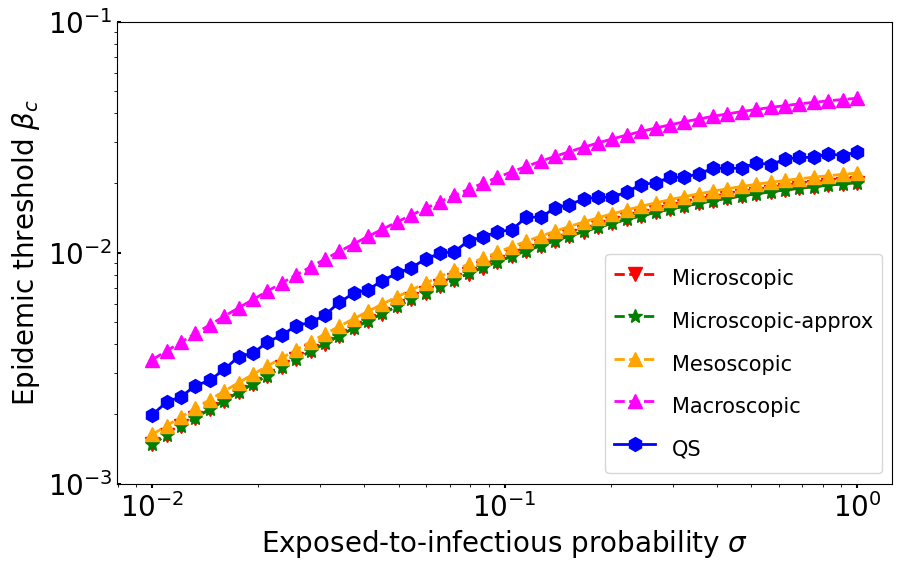

In [19]:
# 加载保存的张量
chis_sigma = torch.load('data/chis_sigma_values.pt')
rho_means_sigma = torch.load('data/rho_means_sigma_values.pt')
beta_log = torch.load('data/beta_log_sigma_values.pt')
sigma = torch.load('data/sigma_values.pt')


max_indices = torch.argmax(torch.nan_to_num(chis_sigma, nan=0.0), dim=1)
beta_c = 10 ** beta_log[max_indices]

print(beta_c)
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(sigma.cpu(), beta_sigma_1, label="Microscopic", marker="v", linestyle="--", color="red", linewidth=2, markersize=10)  # 绘制第一条折线
ax.plot(sigma.cpu(), beta_sigma_2, label="Microscopic-approx", marker="*", linestyle="--", color="green", linewidth=2, markersize=10)  # 绘制第一条折线
ax.plot(sigma.cpu(), beta_sigma_3, label="Mesoscopic", marker="^", linestyle="--", color="orange", linewidth=2, markersize=10)  # 绘制第一条折线
ax.plot(sigma.cpu(), beta_sigma_4, label="Macroscopic", marker="^", linestyle="--", color="magenta", linewidth=2, markersize=10)  # 绘制第一条折线
ax.plot(sigma.cpu(), beta_c, label="QS", marker="h", linestyle="-", color="blue", linewidth=2, markersize=10)  # 绘制第一条折线


# 设置坐标轴标签
ax.set_xlabel(r'Exposed-to-infectious probability $\sigma$', fontsize=20, color='black')
ax.set_ylabel(r'Epidemic threshold $\beta_c$', fontsize=20, color='black')
ax.tick_params(axis='x', labelsize=20, length=3, width=1.5, color='black', direction='out')
ax.tick_params(axis='y', labelsize=20, length=3, width=1.5, color='black', direction='in')
# ax.set_xlim(0.0, 0.2)
ax.set_ylim(10**(-3), 10**(-1))

# 显示图形
ax.legend(fontsize=15, handlelength=2, handleheight=2)
plt.yscale('log')
plt.xscale('log')
# plt.show()

plt.savefig(f'../figs/Num_verification/Threshold/sigma_beta.svg', bbox_inches='tight')